## Purpose

The purpose of this file to provide methods for reliability and failure of using Weibull distributions in Python. Examples of applications include the ability to predict the failure rate of strain-life fatigue as well as the likelihood of a part to fail at a particular stress value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, special

from reliability.Distributions import Weibull_Distribution
from reliability.Fitters import Fit_Weibull_2P
from reliability.Probability_plotting import plot_points

from IPython.display import Markdown as md # used in this notebook to render variables in markdown

## Weibull cdf

Failure rate based on cumulative density function (cdf) of Weibull distribution

$$F = 1 - e^{(-x/\lambda)^k} = 1 - \text{exp}(-x / \lambda)^k$$

Where:
* $x$ = measured variable (ex. time to failure, stress to failure, strain to failure)
* $k$ = shape parameter (k < 1 is decreasing failure rate, k = 1 is exponential decay, k > 1 can model increasing failure rate, k ~ 3.5 is close to normal distibution)
* $\lambda$ = scale parameter (spreads distribution, ie. MTTF)


https://en.wikipedia.org/wiki/Weibull_distribution#:~:text=In%20probability%20theory%20and%20statistics,spends%20on%20a%20web%20page.

# Methods for finding shape and scale parameters

## With Raw Data

In [2]:
rng = np.random.default_rng()  # random numnber generator

[Text(0.5, 0, 'Value'), Text(0, 0.5, 'Count')]

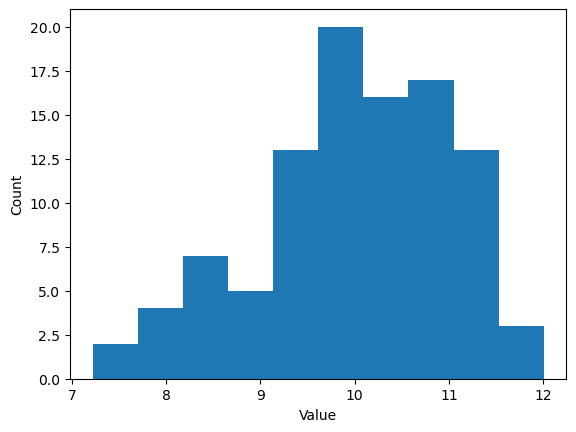

In [3]:
n = 100
x = rng.normal(10, size=n)  # random normal distribution

fig, ax = plt.subplots()
ax.hist(x)

ax.set(xlabel="Value", ylabel="Count")

### Linear Regression

Use log conversions to make a linear plot of the data and fit a regression line

Derivation:
$$\frac{1}{1-F} = exp\left(\frac{x}{\lambda}\right)^k$$
$$ln\left(\frac{1}{1-F}\right) = \left(\frac{x}{\lambda}\right)^k$$
$$ln\left(ln\left(\frac{1}{1-F}\right)\right) = k ln x - k ln \lambda$$
$$y = m x + b$$

Alternate notation
$$x_i = ln(X_i)$$
$$y_i = ln[-ln(1-p_i)]$$

In [4]:
measurement_id = np.arange(n)

df = pd.DataFrame({"raw_data": x, "measurement_id": measurement_id})
df = df.sort_values(by=["raw_data"]).reset_index()
df["rank"] = df["raw_data"].rank()

df["failure_rate"] = (df["rank"]-0.5)/ len(df)
df["weibull_modulus"] = np.log(np.log(1/(1-df["failure_rate"])))
df["log_measurement"] = np.log(df["raw_data"])
df.head()

,index,raw_data,measurement_id,rank,failure_rate,weibull_modulus,log_measurement
0,71,7.22207,71,1,0.005,-5.29581,1.97714
1,30,7.58888,30,2,0.015,-4.19216,2.02668
2,25,7.85006,25,3,0.025,-3.67625,2.06052
3,80,7.90082,80,4,0.035,-3.33465,2.06697
4,49,7.93915,49,5,0.045,-3.07816,2.07181


In [5]:
reg = stats.linregress(df["log_measurement"], df["weibull_modulus"])
k_reg = reg.slope
b = reg.intercept
lambda_reg = np.exp(-b/k_reg)
print(k_reg, lambda_reg)

11.774639117099765 10.443904280481405


[Text(0.5, 0, '$ln(x)$'),
 Text(0, 0.5, '$ln\\left(ln\\left(\\frac{1}{1-F}\\right)\\right)$')]

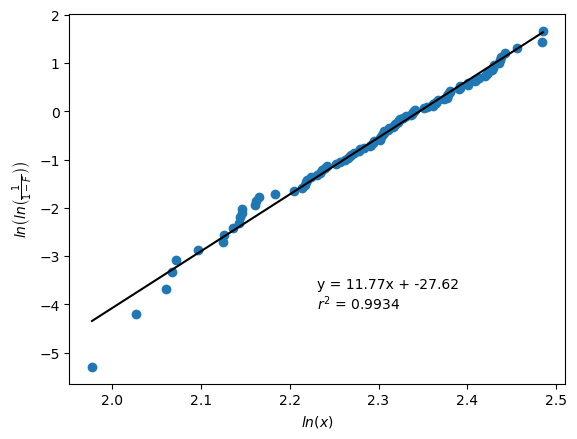

In [6]:
fig, ax = plt.subplots()

ax.scatter(df["log_measurement"], df["weibull_modulus"])
ax.plot(df["log_measurement"], k_reg*df["log_measurement"] + b, color="k")

regress_string = f"y = {k_reg:0.4}x + {b:0.4} \n" \
                    f"$r^2$ = {reg.rvalue:0.4}"
ax.text(x=0.5, y=0.2, s=regress_string, transform=ax.transAxes)

ax.set(xlabel="$ln(x)$", ylabel="$ln\\left(ln\\left(\\frac{1}{1-F}\\right)\\right)$")

[Text(0.5, 0, 'Value'), Text(0, 0.5, 'Density')]

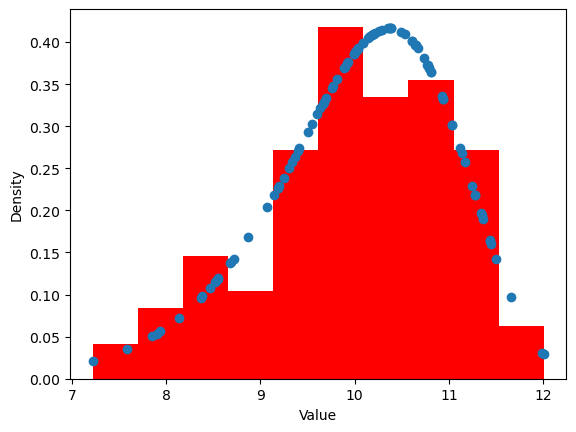

In [7]:
fig, ax = plt.subplots()

ax.hist(x, density=True, color="r")
ax.scatter(x, stats.weibull_min.pdf(x, k_reg, 0, lambda_reg))

ax.set(xlabel="Value", ylabel="Density")

### Weibull fit using Scipy Stats

Notation used for scipy exponential Weibull:

$$F = [1 - e^{-x^c}]^a = [1 - \text{exp}(-x^c)]^a$$

[Text(0.5, 0, 'Value'), Text(0, 0.5, 'Density')]

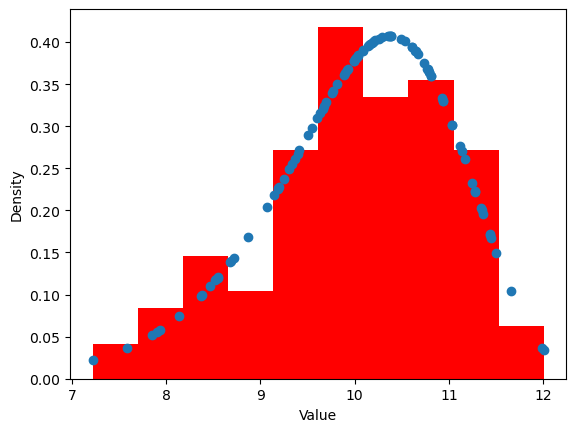

In [13]:
fig, ax = plt.subplots()

ax.hist(x, density=True, color="r")
ax.scatter(x, stats.exponweib.pdf(x, *stats.exponweib.fit(x, floc=0, f0=1, method="MLE")))

ax.set(xlabel="Value", ylabel="Density")

In [12]:
exponweib_param = [*stats.exponweib.fit(x, floc=0, f0=1, method="MLE")]
a = exponweib_param[0]
c = exponweib_param[1]
loc = exponweib_param[2]
scale = exponweib_param[3]

print(f"Exponential Weibull Parameters: a = {a}, c = {c:.4}, Location (loc)= {loc}, Scale = {scale:.4}")

Exponential Weibull Parameters: a = 1, c = 11.52, Location (loc)= 0, Scale = 10.45


The "Two-Parameter" Weibull function used for reliability is the **"weibull_min"** function in scipy. This is a special case of the exponentiated function where $a = 1$

$$F = 1 - e^{-x^c} = 1 - \text{exp}(-x^c)$$

[Text(0.5, 0, 'Value'), Text(0, 0.5, 'Density')]

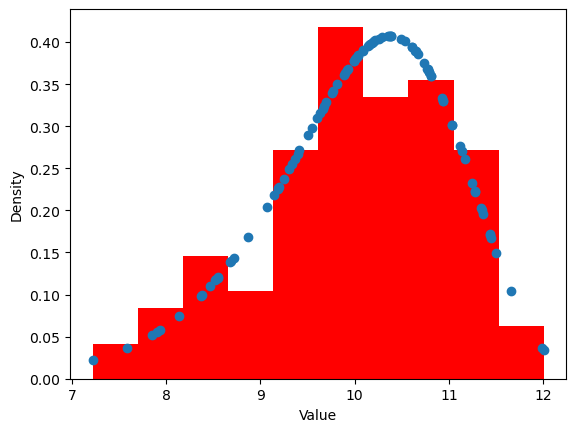

In [14]:
fig, ax = plt.subplots()

ax.hist(x, density=True, color="r")
ax.scatter(x, stats.weibull_min.pdf(x, *stats.weibull_min.fit(x, floc=0, method="MLE")))

ax.set(xlabel="Value", ylabel="Density")

In [16]:
exponweib_param = [*stats.weibull_min.fit(x, floc=0, method="MLE")]

c = exponweib_param[0]
loc = exponweib_param[1]
scale = exponweib_param[2]

print(f"Exponential Weibull Parameters: c = {c:.4}, Location (loc)= {loc}, Scale = {scale:.4}")

Exponential Weibull Parameters: c = 11.52, Location (loc)= 0, Scale = 10.45


### Weibull fit with reliability package

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 100/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         10.4535       0.0956466   10.2677   10.6427
     Beta          11.523        0.900605   9.88636   13.4305 

Goodness of fit    Value
 Log-likelihood -142.551
           AICc  289.226
            BIC  294.313
             AD 0.334853 



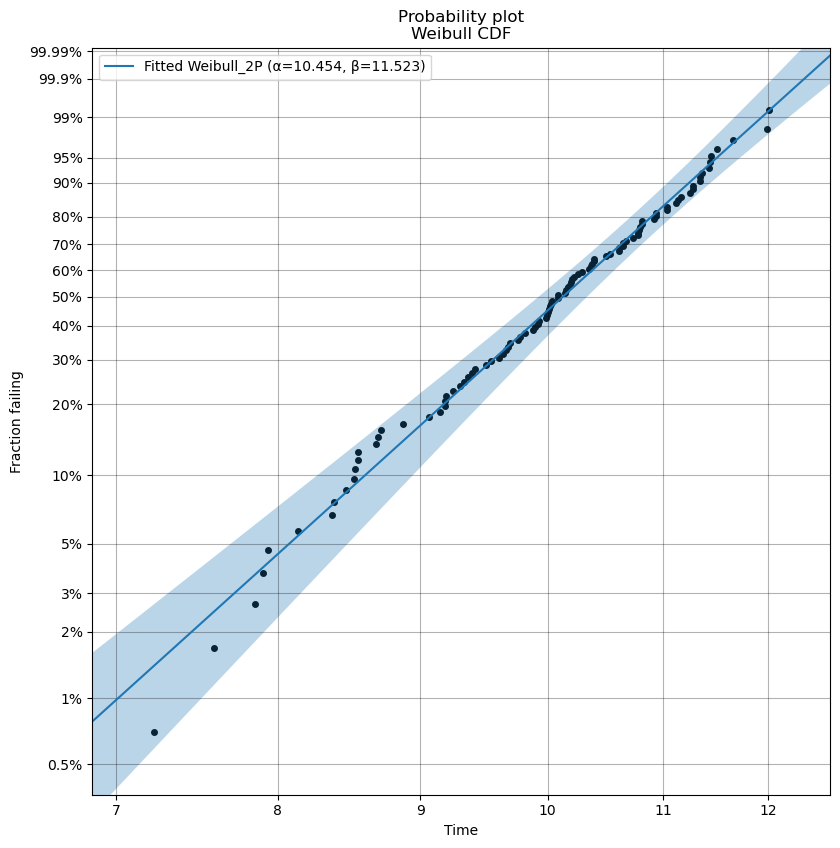

In [17]:
fit = Fit_Weibull_2P(failures=x)  # fits a Weibull distribution to the data and generates the probability plot

## Without raw data

In many instances the raw data is not available, so the mean and variance can be used through the **method of moments**

### Method of moments

"Method of moments" can be used to estimate the scale and shape parameters given the mean and standard deviation 

Mean
$$E(X) = \lambda \Gamma \left(1 + \frac{1}{k}\right)$$

Variance
$$var(X) = \lambda^2\left[\Gamma\left(1 + \frac{2}{k}\right) - \left(\Gamma\left(1+\frac{1}{k}\right)\right)^2\right]$$

$$k = \left(\frac{\sigma}{\bar{x}}\right)^{-1.086}$$
$$\lambda = \frac{\bar{x}}{\Gamma(1 + 1/k)}$$

In [18]:
std = np.std(x)
mean = np.mean(x)

k = (std/mean)**(-1.086)
scale_parameter = (mean/(special.gamma(1 + (1/k))))

print(f"Mean: {mean:.4}, Standard deviation: {std:.4}, Shape parameter, k: {k:.4}, Scale parameter: {scale_parameter:.4}")

Mean: 10.0, Standard deviation: 1.031, Shape parameter, k: 11.8, Scale parameter: 10.44


[Text(0.5, 24.0, 'Value'), Text(24.000000000000007, 0.5, 'Density')]

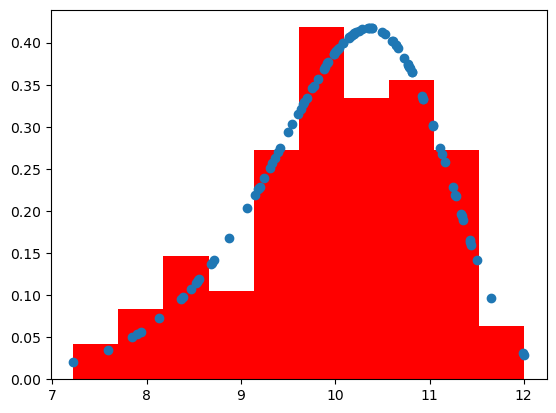

In [19]:
fig, ax = plt.subplots()

ax.hist(x, density=True, color="r")
ax.scatter(x, stats.weibull_min.pdf(x, k, 0, scale_parameter))

ax.set(xlabel="Value", ylabel="Density")

## Comparing Fits (ADD IN FUTURE)

# Adjusting Failure Statistics for Size Scale Effects (Effective area/ volume)

Material strength test samples are typically a different size from the part in a real-world application.  A material will a larger stressed area or volume with have more statistical changes for weak points to cause failure. A size scale correction for the strength of the material can be made using the shape of the strength distribution and the ratio of the sizes. This correction becomes more important for brittle materials such as ceramics which can have high standard deviations for strength measurements due to the strong influence of flaws on the materials.

$$x_{actual} = x_{sample} \left(\frac{\text{geometric size of sample}}{\text{geometric size of actual part}}\right)^{1/k}$$

As an example the strength at some failure probability for a actual part can be predicted from the relative size of the test specimen and the actual part.

$$\sigma_{actual} = \sigma_{sample} \left(\frac{A_{sample}}{A_{actual}}\right)^{1/k}$$